In [2]:
pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 21.9 MB/s eta 0:00:00a 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 11.7 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [12]:
import os
import json
import glob
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List

class VoyagerAnalyzer:
    def __init__(self, checkpoint_dirs: List[str]):
        """Initialize analyzer with multiple checkpoint directories to compare."""
        self.checkpoint_dirs = checkpoint_dirs
        self.runs_data = {}
        
        for ckpt_dir in checkpoint_dirs:
            self.runs_data[ckpt_dir] = self._load_run_data(ckpt_dir)
    
    def _load_run_data(self, ckpt_dir: str) -> Dict:
        """Load all event files from a checkpoint directory."""
        events_dir = os.path.join(ckpt_dir, "events")
        event_files = sorted(glob.glob(os.path.join(events_dir, "*")))
        
        positions = []
        items_over_time = []
        unique_items = set()
        elapsed_time = 0
        
        for event_file in event_files:
            with open(event_file) as f:
                events = json.load(f)
                
            for event_type, event in events:
                # Track position
                if "status" in event:
                    pos = event["status"]["position"]
                    positions.append([pos["x"], pos["z"]])
                
                # Track items
                if "inventory" in event:
                    new_items = set(event["inventory"].keys())
                    unique_items.update(new_items)
                    items_over_time.append({
                        "time": elapsed_time,
                        "item_count": len(unique_items)
                    })
                
                # Track time
                if event_type == "observe":
                    elapsed_time += event["status"]["elapsedTime"]
        
        return {
            "positions": positions,
            "items_over_time": items_over_time
        }
    
    def plot_trajectories(self):
        """Plot XZ trajectories for all runs on the same graph."""
        plt.figure(figsize=(12, 8))
        
        for run_name, data in self.runs_data.items():
            positions = np.array(data["positions"])
            plt.plot(positions[:, 0], positions[:, 1], 
                    label=os.path.basename(run_name),
                    alpha=0.7)
        
        plt.title("Bot Trajectories")
        plt.xlabel("X Position")
        plt.ylabel("Z Position")
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def plot_item_collection(self):
        """Plot unique items collected over time for all runs."""
        plt.figure(figsize=(12, 8))
        
        for run_name, data in self.runs_data.items():
            items_data = data["items_over_time"]
            times = [d["time"] for d in items_data]
            counts = [d["item_count"] for d in items_data]
            
            plt.plot(times, counts,
                    label=os.path.basename(run_name),
                    alpha=0.7)
        
        plt.title("Unique Items Collected Over Time")
        plt.xlabel("Time (ticks)")
        plt.ylabel("Number of Unique Items")
        plt.legend()
        plt.grid(True)
        plt.show()


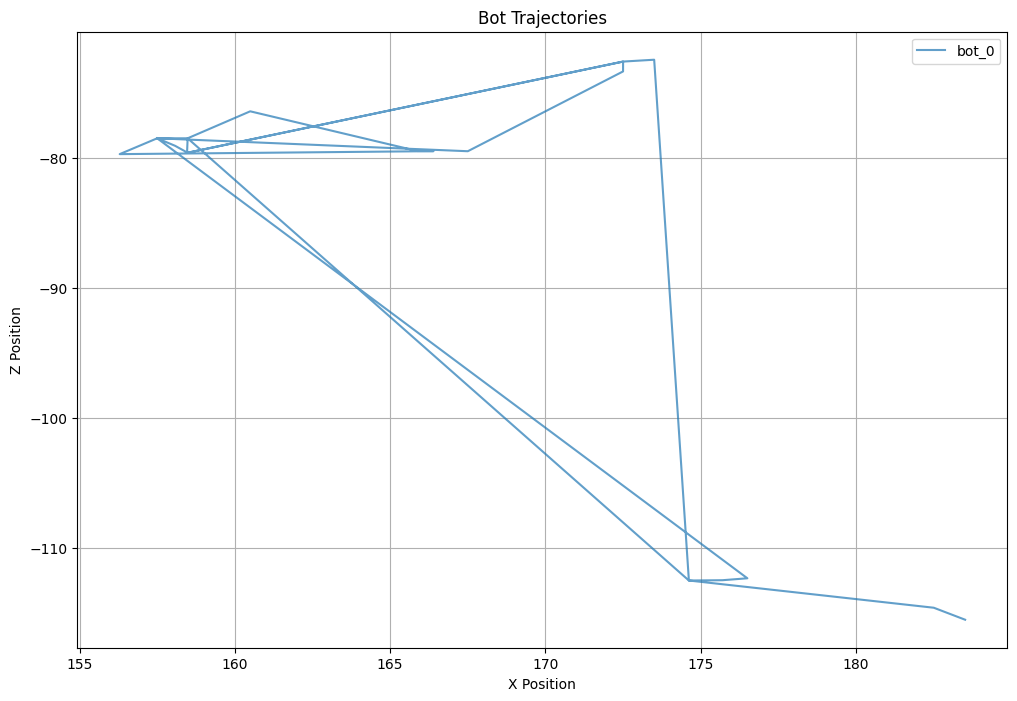

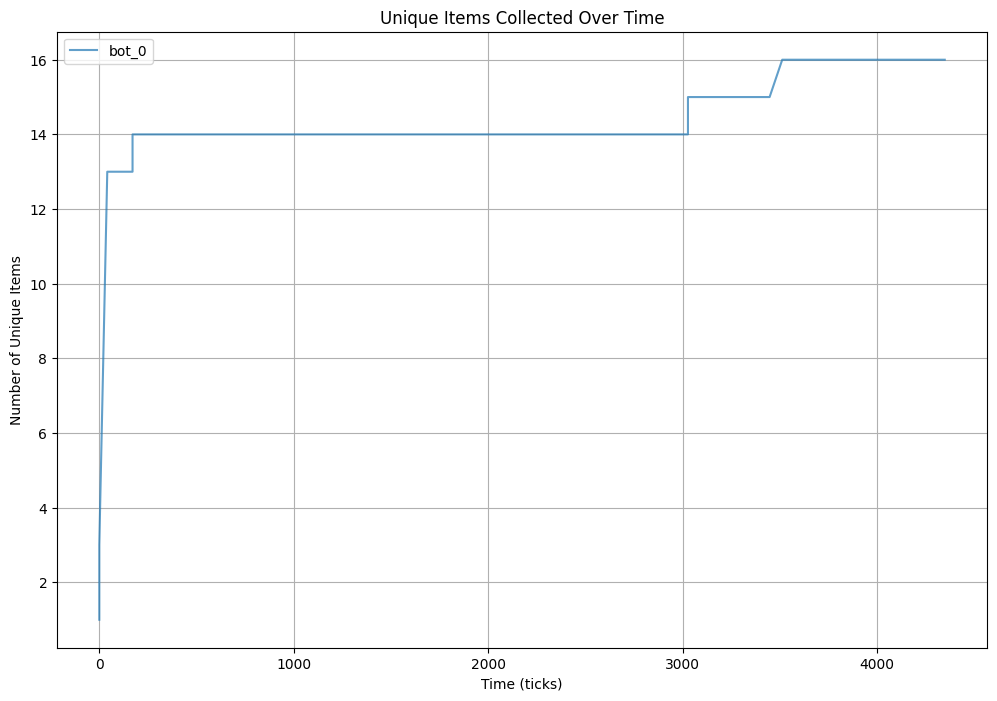

In [13]:
# Example usage:
checkpoint_dirs = [
    "/Users/albertohojel/TheWay/llm_agents/Voyager2/test1/bot_0",
]

analyzer = VoyagerAnalyzer(checkpoint_dirs)
analyzer.plot_trajectories()
analyzer.plot_item_collection()